<h1 style="property:value; background-color:skyblue;" align="center"> TS Forecasting methods

In [63]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import plotly.io as pio
from warnings import catch_warnings, filterwarnings
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
# set some display options:
pio.templates.default = "plotly_white"

# Import Statsmodels
from statsmodels.tsa.api import VAR
# from statsmodels.tools.eval_measures import rmse, aic
from pmdarima.arima import auto_arima, ARIMA

from forecast_utils import neighbor_cells, divide_data, EXP_Smoothing,\
                           create_acf_pacf, MLP_Forecasting, plot_forecasting

from evaluations import nrmse, mape

%matplotlib inline

#### Import the data

In [5]:
full_data = np.load('../Data/full_data_imputed.npy')

## Uni-Variant TS Forecasting
For univariant TS we have:
- Statistical methods:
    - Common Approaches:
        - Trend, Seasonal, Residual Decompositions:
            - Seasonal Extraction in ARIMA Time Series (SEATS).
            - Seasonal and Trend decomposition using Loess (STL).
            - Exponential smoothing:
                - Single Exponential Smoothing, or SES, for univariate data without trend or seasonality.
                - Double Exponential Smoothing for univariate data with support for trends.
                - Triple Exponential Smoothing, or Holt-Winters Exponential Smoothing, with support for both trends and seasonality.(TES)

        - Autoregressive Models (AR).
        - Moving Average Models (MA).
    - Box–Jenkins Approaches: 
        - ARIMA.
        - SARIMA.
    - Deep Learning Approaches:
        - MLP Approaches.
        - CNN Approaches.
        - LSTM Approaches.
        
#### 1) Triple Exponential Smoothing, or Holt-Winters
Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.<br>
Its hyperparameters :
- smoothing_level (alpha): the smoothing coefficient for the level.
- smoothing_slope (beta): the smoothing coefficient for the trend.
- smoothing_seasonal (gamma): the smoothing coefficient for the seasonal component.
- damping_slope (phi): the coefficient for the damped trend.

### Statistical methods

>##### Lets deal with grid (49, 49) as our TS data (Endogenous).
>##### We can use the other data (8 neighbors) as exongeous variables.

In [6]:
# neighbor cells are zero for univarite
df = neighbor_cells(data=full_data, neighbor_radius=0, cell_center=[49, 49], uni_variant=True)
df.head()

,time,Target
0,1970-01-01 01:00:00,310.155506
1,1970-01-01 01:00:10,280.956861
2,1970-01-01 01:00:20,234.586820
3,1970-01-01 01:00:30,245.016625
4,1970-01-01 01:00:40,203.336927


#### Visualize the Time Series

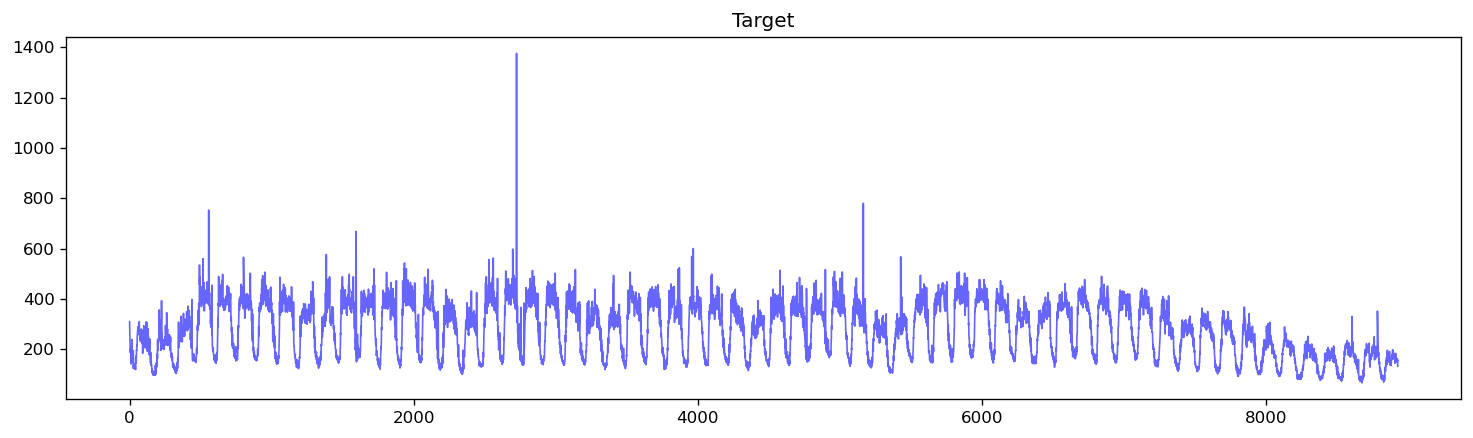

In [19]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(15, 4))
ax.set_title('Target')
ax.plot(df['Target'], color='b', linewidth=1, alpha=0.6);

#### Describe the data

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,8928.0,280.411999,104.753522,67.103045,180.72744,291.166044,371.409049,1375.244527


#### Missing values

In [21]:
df.isna().sum()

time      0
Target    0
dtype: int64

### Sliding Window Forecasting
- Window size = 30 days
    - Forecast one day.
    - Forecast one week.

#### Before start forecasting let's see the correlation between some random grids's values by plotting ACF and PCAF.

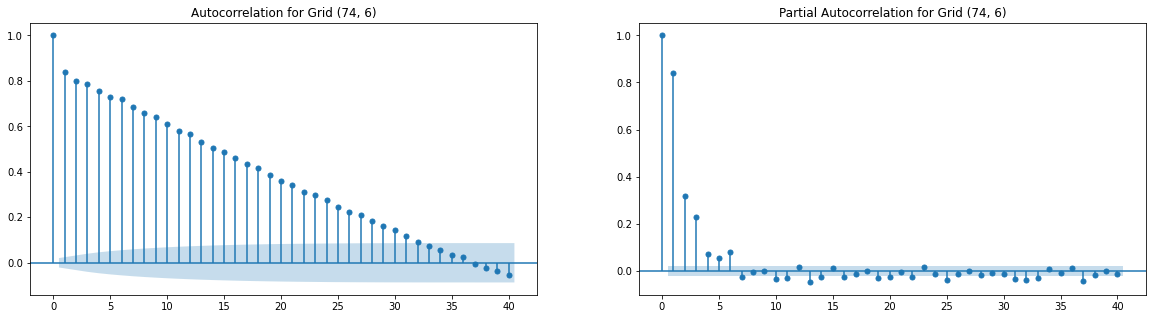

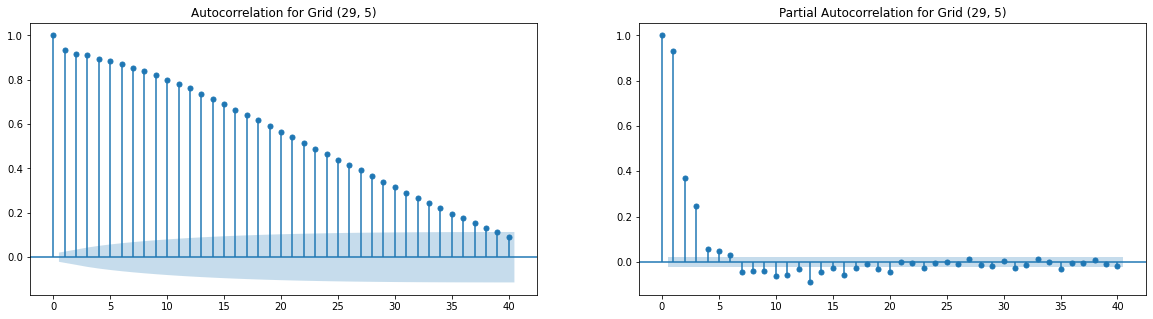

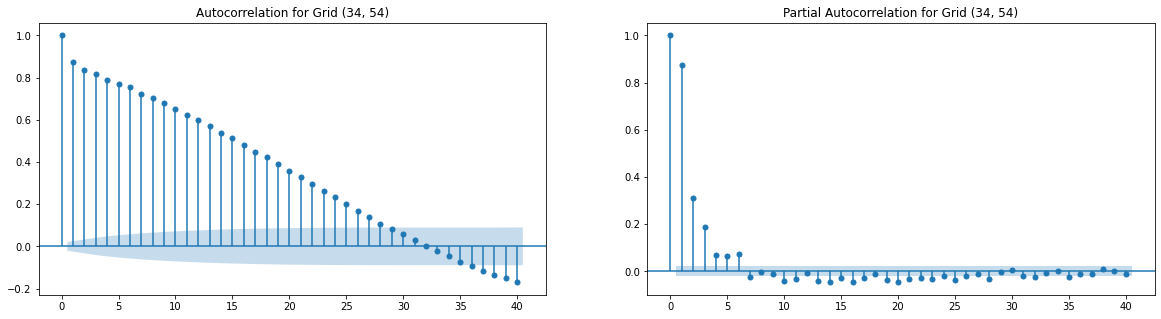

In [65]:
for i in range(3):
    
    x= np.random.randint(0,100)
    y= np.random.randint(0,100)
    
    series = neighbor_cells(data=full_data, neighbor_radius=0, 
                            cell_center=[x,y], uni_variant=True)['Target']
    
    create_acf_pacf(series, 'Grid (%d, %d)'%(x, y))

#### For ACF:
- Most of spikes are significant.
- All othem are between 0.2 - 1.0.

It shows that the effects are decaying over time, that means that future values of the series are correlated heavily by past values.<br>
The more lags we include, the better the model will fit the data set we feed.

#### For PACF:
- Coefficient in different size.
- Ther're coefficients are neg(-).
- Ther're coefficients are not significant.(Farest Coefficient)

So, i think we can include 20 past values in our forecasting model.

### Forecasting

In [24]:
with catch_warnings():
    
    filterwarnings("ignore")
    
    window_size = 30
    data_iter = (full_data.shape[0]//144) - window_size

    Results = {'Exponintial Smoothing' : {'Days':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(data_iter)},
                                          'Weeks':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(4)}},
               'MLP' : {'Days':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(data_iter)},
                        'Weeks':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(4)}}}

    # iterating over the last 32 days
    for i in range(0, data_iter, 1):
        
        #### day predictions
        print('='*10,'Day %s'%(i+1),'='*10)
        
        # gathering the data
        X_train ,future_day ,full_predict = divide_data(i, df, "month" , "day")

        # 1) MLP
        Multi_Step_MLP = MLP_Forecasting(X_train)
        Multi_Step_MLP.build_dense_layers(6*144, 144, 2048, scale=True, epochs=100, lr=0.0001, batch=64, verbose=0) 
        Results['MLP']['Days'][str(i+1)]['results'],Results['MLP']['Days'][str(i+1)]['errors'] = Multi_Step_MLP.forecast(future_day)
        print('=> MLP is done!')
        
        # 2) Exponintial Smoothing
        args = {'trend':'mul', 'seasonal':'mul', 'seasonal_periods':144}
        results, errors = EXP_Smoothing(X_train, future_day, args)
        Results['Exponintial Smoothing']['Days'][str(i+1)]['results'] = results
        Results['Exponintial Smoothing']['Days'][str(i+1)]['errors'] = errors
        print('=> Exponintial Smoothing!\n')

        #         if i%7==0:
        #             results = pd.DataFrame({'Actual':future_week['Target'].values ,'Forecasting':EXP_smooth_pred.values})
        #             results.index = future_week.index
        #             Results['Exponintial Smoothing'][str(w+1)] = results

========== Day 1 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 2 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 3 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 4 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 5 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 6 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 7 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 8 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 9 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 10 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 11 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 12 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 13 ==========
=> MLP is done!
=> Exponintial Smoothing!

========== Day 14 ==========
=> MLP is done!
=> Exponintial Smoothing!

=

### Let's visualize random days

In [146]:
def plot_forecasting(real:pd.DataFrame, Results:dict, legend:list, models:list, w, day_week='Day', previous_steps=300):
    
    if len(models)==1:
        data = Results['%s'%models[0]]['%s'%day_week]['%d'%w]['results'].rename(columns={'Predictions':'%s'%models[0]})\
               .reset_index()
        
        plt.figure(figsize=(20,8))
        plt.title('Forecasting day %d'%w, fontsize=20)
        plt.plot(data['Target'][-previous_steps:], lw=2.5, label='Actual', color='#03396c')
        plt.plot(temp[['%s'%models[0],'time']].set_index('time'), lw=2.5, label='%s'%legend[0])
        max_ = temp.drop(['Target','time'],axis=1).values.max()
        plt.vlines(x=temp['time'].min(),ymin=0, ymax=max_, linestyle='dashed', color='#4a4e4d', label='Start Forecasting')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Value', fontsize=18)
        plt.legend()
        plt.show()
        
    else:
        temp = Results['%s'%models[0]]['%s'%day_week]['%d'%w]['results'].rename(columns={'Predictions':'%s'%models[0]})\
               .reset_index()
        
        plt.figure(figsize=(20,8))
        plt.title('Forecasting day %d'%w, fontsize=20)
        plt.plot(real['Target'][-previous_steps:], lw=2.5, color='#03396c', alpha=0.7, label='Actual')
        plt.plot(temp[['%s'%models[0],'time']].set_index('time'), label='%s'%legend[0])
        
        for i, model in enumerate(models[1:]):
            data = Results['%s'%model]['%s'%'Days']['%d'%w]['results'].rename(columns={'Predictions':'%s'%model})['%s'%model]
            plt.plot(data, label='%s'%legend[i+1])

        max_ = temp.drop(['Target','time'],axis=1).values.max()
        plt.vlines(x=temp['time'].min(),ymin=0, ymax=max_, linestyle='dashed', color='#4a4e4d', label='Start Forecasting')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Value', fontsize=18)
        plt.legend()
        plt.show()

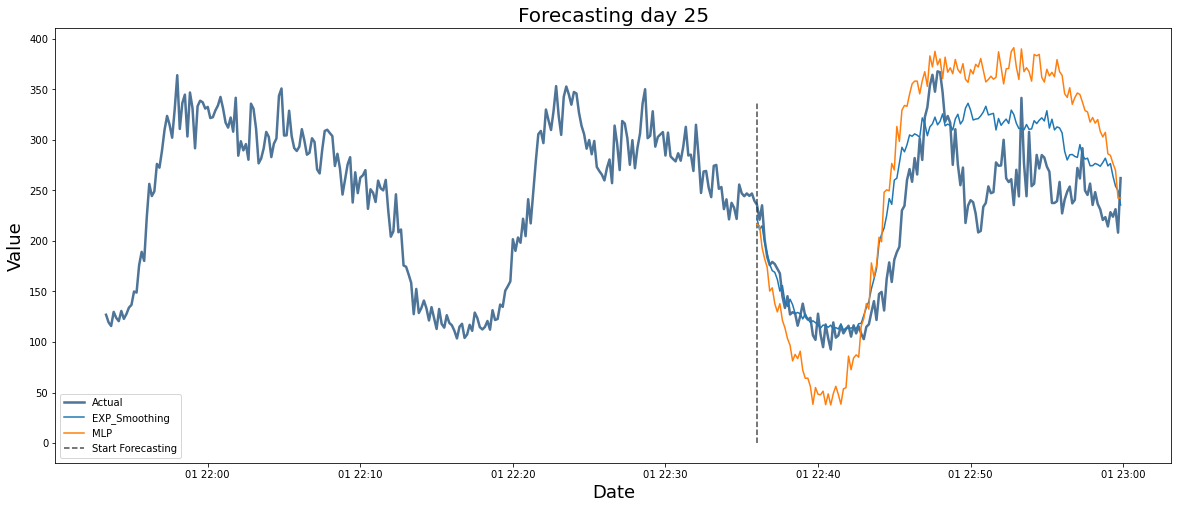

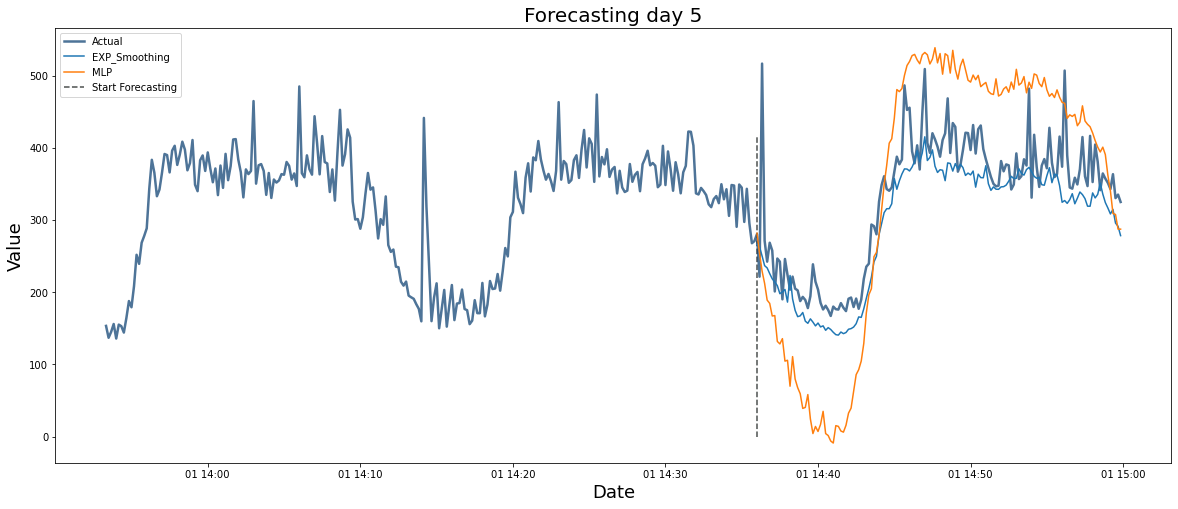

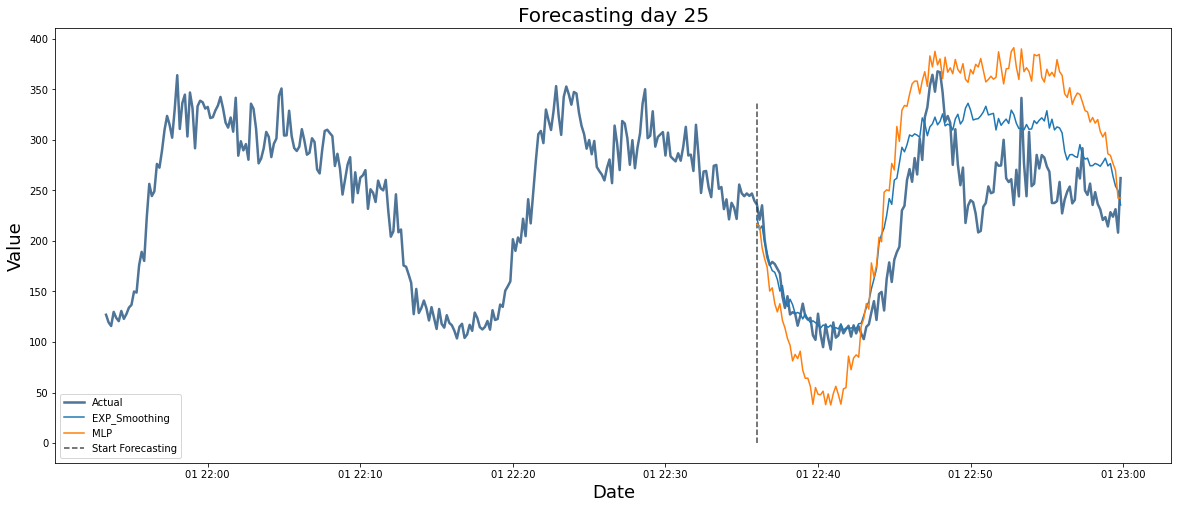

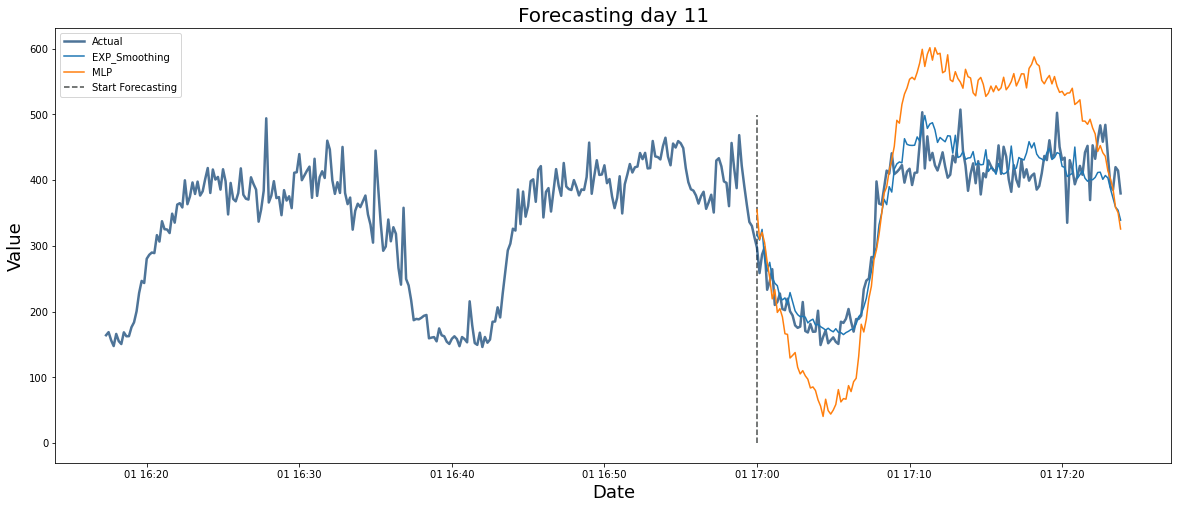

In [147]:
for _ in range(4):
    i = np.random.randint(1,32) 
    X_train, _, _ = divide_data(i, df, "month" , "day")
    plot_forecasting(X_train, 
                     Results,
                     ['EXP_Smoothing','MLP'], 
                     ['Exponintial Smoothing', 'MLP'], i, 'Days', 400)

#### Visualizing the errors

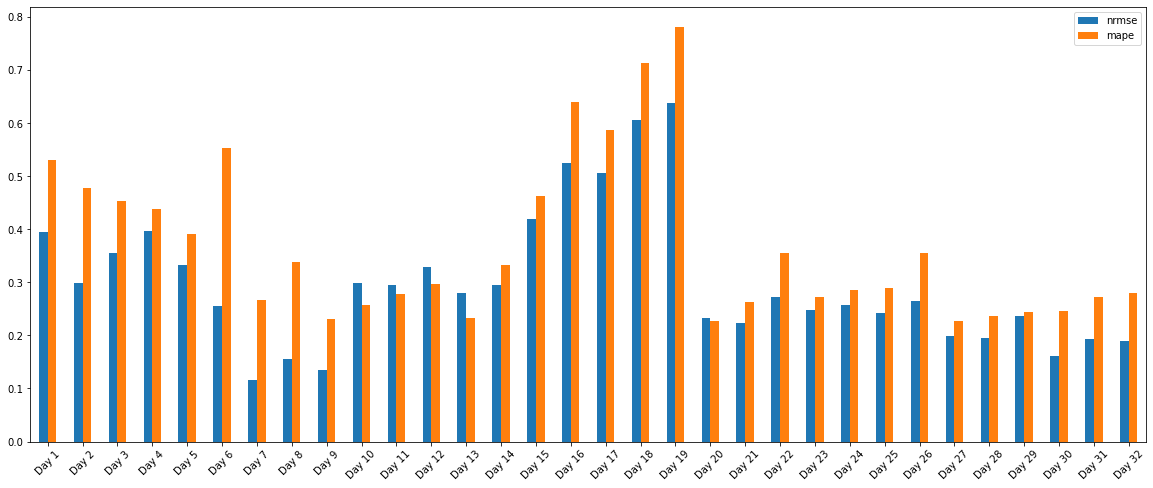

In [172]:
errors = pd.DataFrame(index=['Day %s'%i for i in range(1,33,1)])
errors['nrmse'] = [Results['MLP']['Days']['%d'%(i+1)]['errors']['nrmse'] for i in range(32)]
errors['mape'] = [Results['MLP']['Days']['%d'%(i+1)]['errors']['mape'] for i in range(32)]

errors.plot(kind='bar', figsize=(20,8), rot='45');